### DTSA 5511 Introduction to Deep Learning - Mini Project 3
Project Title: Monetifier with CycleGAN <br>
Date: 2023 Dec 4 <br>
Author: Tsai-Yun Li <br>
Course Lecturer: Geena Kim <br>
Orginzation: University of Colorado Boulder <br>
Kaggle Competition Name: I’m Something of a Painter Myself <br>
GitHub Repository Link:
https://github.com/TsaiYunLi/ML3_Miniporj3_TsaiYunLi

### Table of Contents
<br> 1. Problem Description
<br> 2. Data Description
<br> 3. Exploratory Data Analysis (EDA)
<br> 3.1 Image Basic EDA
<br> 3.2 Image Preprocessing for Model Input
<br> 4. The CycleGAN Model
<br> 4.1 Defining the Generators G and F
<br> 4.2 Defining the Discriminators Dy and Dx
<br> 4.3 Defining the Optimizers for G, Dy, F, and Dx
<br> 4.4 Defining the Adversarial, Cycle Consistency, and Identity Loss Functions
<br> 4.5 Setting up the CycleGAN Training Procedure
<br> 4.6 Training the CycleGAN Model
<br> 5. Results
<br> 6. Conclusion and Limitations
<br> 7. References

### 1. Problem Description
This is a non-awarding, for-knowledge Kaggle practice for the application of generative adversarial networks (GANs) on photo style transfer. We are asked to use a model in the GANs family to learn from the provided Monet paintings and normal photos in order to 'monetify' the latter, i.e. to make the photos Monet-like. There are no paired examples in the datasets; that is, there is no direct, one-to-one correspondence between a photo and a Monet painting in the datasets. Analogically speaking, the datasets are 'unlabeled.' 

There are several common GANs model candidates, including Deep Convolutional GANs (DCGANs), Conditional GANs, and CylceGAN. Among all of them, CycleGAN is most suitable for this Kaggle task, since it is an unsupervised, generative, deep learning model, specialized in traslating images from one domain X (the Monet paintings) to the other domain Y (the ordinary photos) without paired examples.

However, due to the very complex structure of a CycleGAN model and my first attempt of doing a project in this domain, I decided to perform a 'transfer learning' using the CycleGAN architecture with the optimal model hyperparameters and training tips described in both Wolf's 2018 and Shrivastava et al.'s 2016 articles. That is, my CycleGAN model to be built for this project would closely follow their 'blueprints,' not only to increase the possibility of completing the Kaggle task, but also to serve as a good opportunity for me to learn about and understand a CycleGAN model in more depth.

P.s. Please see links in the reference section for the Kaggle task overview and datasets, as well as the heavily cited Wolf 2018 and Shrivastava et al 2016 articles.

### 2. Data Description
The datasets provided by Kaggle for this task includes four files, quoting directly from the platform:
<br> "monet_jpg - 300 Monet paintings sized 256x256 in JPEG format
<br>   monet_tfrec - 300 Monet paintings sized 256x256 in TFRecord format
<br>   photo_jpg - 7028 photos sized 256x256 in JPEG format
<br>   photo_tfrec - 7028 photos sized 256x256 in TFRecord format"

I decided to use the JPEG format ones in my project and imported them as monet_dataset and photo_dataset. However, when I loaded the images from the photo_jpg directory, I found out that it acutally contains 7038 photos. This probably won't affect the model training too much. Just pointing this out for a more accurate description of the datasets.

Besides, since the number of images in the monet_dataset and the photo_dataset  are very much imbalanced, I need to make sure the CycleGAN model see more modet_dataset images than the ones in photo_dataset when training the model in section 4.6.

I visualized 6 random Monet paintings and normal photos from the monet_dataset and the photo_dataset just to get a rough idea of how the images in the datasets look like.

P.s. Please see link in the reference section for the Kaggle datasets.

In [1]:
! pip install tensorflow

In [2]:
## Image Data Importing and Loading
# importing the image datasets
import tensorflow as tf
import os
import matplotlib.pyplot as plt

monet_dir = '/kaggle/input/gan-getting-started/monet_jpg'  
photo_dir = '/kaggle/input/gan-getting-started/photo_jpg'  

In [3]:
# loading the image datasets
def load_images(directory):
    dataset = tf.data.Dataset.list_files(os.path.join(directory, '*.jpg'))
    dataset = dataset.map(lambda x: tf.image.decode_jpeg(tf.io.read_file(x), channels=3))
    return dataset

monet_dataset = load_images(monet_dir)
photo_dataset = load_images(photo_dir)

In [4]:
# checking the size of the image datasets
print(f'The monet_dataset contains {len(monet_dataset)} paintings in jpg format.')
print(f'The photo_dataset contains {len(photo_dataset)} photos in jpg format.')

The monet_dataset contains 300 paintings in jpg format.
The photo_dataset contains 7038 photos in jpg format.


The number of images in these two datasets are very much imbalanced. I need to make sure my CycleGAN model see more modet_dataset images than the ones in photo_dataset when training the model in section 4.6.

In [5]:
## Visual Inspection 
# inspecting some random images from the image datasets
def show_images(dataset, num_images):
    plt.figure(figsize=(10, 10))
    for i, image in enumerate(dataset.take(num_images)):
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.axis("off")

6 random Monet paintings from the monet_dataset:


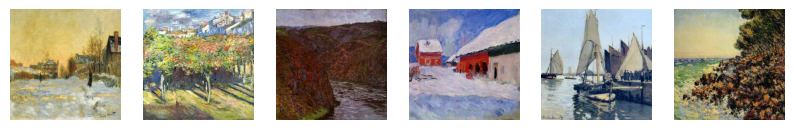

In [6]:
print("6 random Monet paintings from the monet_dataset:")
show_images(monet_dataset, 6)

6 random photos from the photo_dataset:


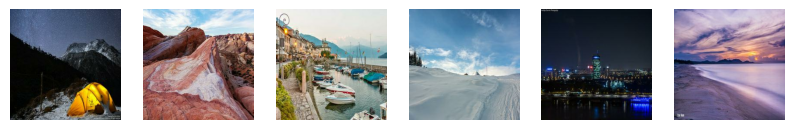

In [7]:
print("6 random photos from the photo_dataset:")
show_images(photo_dataset, 6)

### 3. Exploratory Data Analysis and Image Preprocessing

### 3.1 Image Basic EDA

In [8]:
## Image Shape Analysis
# checking image shape: height in pixels, width in pixels, color channel
def get_image_shapes(dataset, num_samples=None):
    shapes = []
    for image in dataset.take(num_samples if num_samples else len(dataset)):
        shapes.append(image.shape)
    return shapes

monet_shapes = get_image_shapes(monet_dataset)
photo_shapes = get_image_shapes(photo_dataset)

def analyze_shapes(shapes):
    unique_shapes = set(shapes)
    if len(unique_shapes) == 1:
        print("all images have the same shape:", unique_shapes.pop())
    else:
        print("found different image shapes:", unique_shapes)

print("monet_dataset shape analysis:")
analyze_shapes(monet_shapes)
print("photo_dataset shape analysis:")
analyze_shapes(photo_shapes)

monet_dataset shape analysis:
all images have the same shape: (256, 256, 3)
photo_dataset shape analysis:
all images have the same shape: (256, 256, 3)


Since all images have height and width both in 256 pixels and are all in RGB color mode, I do not need to check for aspect ratio or to perform standardization. I also do not need to resize the images, since 256x256 pixels is the typical image size for the CycleGAN model.

In [9]:
## Image Color Analysis
# checking image color distribution
# color intensity value in range [0, 255]
import matplotlib.pyplot as plt
import numpy as np

def plot_color_distribution(dataset,dataset_name, num_samples):
    R, G, B = [], [], []
    for image in dataset.take(num_samples):
        R.append(image[:, :, 0].numpy().flatten())
        G.append(image[:, :, 1].numpy().flatten())
        B.append(image[:, :, 2].numpy().flatten())

    R = np.concatenate(R)
    G = np.concatenate(G)
    B = np.concatenate(B)

    plt.figure(figsize=(10, 4))
    plt.hist(R, bins=30, color='red', alpha=0.5, label='Red channel')
    plt.hist(G, bins=30, color='green', alpha=0.5, label='Green channel')
    plt.hist(B, bins=30, color='blue', alpha=0.5, label='Blue channel')
    plt.title(f'{dataset_name} Color Distribution ')
    plt.xlabel('Color Intensity Value in Range [0, 255]')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

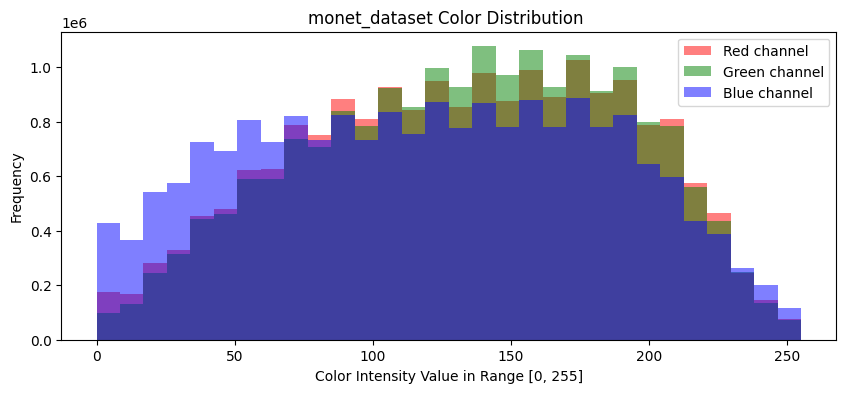

In [10]:
plot_color_distribution(monet_dataset, "monet_dataset", len(monet_dataset))

Blue is the dominant color of monet_dataset paintings because it has a high frequency accross most of the color intensity range. While, red and green are often used in a mid-tone, i.e., not so bright or dark, in monet_dataset paintings because they both have a relatively high freqency in the middle of the color intensity range.

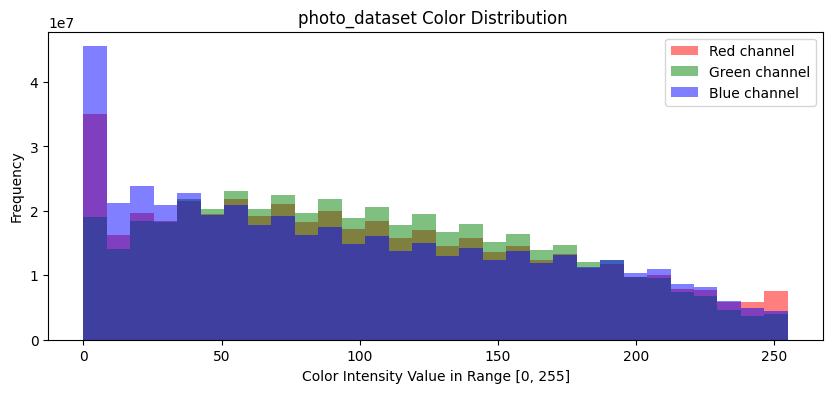

In [11]:
plot_color_distribution(photo_dataset, "photo_dataset", len(photo_dataset))
print()

Darker red and blue are prominent in the photos of the photo_dataset, because the red and blue channels have an apparent high frequency in lower color intensity range.The photos in photo_dataset are generally dark, since the color channel frequency decreases as the color intensity increases.

The color distributions of monet_dataset and photo_dataset are quite different. This might potentially influence the style transfer of the photos to monet-like ones. However, I do not know how to mitigate this.

### 3.2 Image Preprocessing for Model Input

In [12]:
## Normalization
# scaling the pixel values from range [0, 255] to range [-1, 1] 
# which works well with the tanh activation function in the generator output
def normalize_image(image):
    # casting the images to dtype tf.float32
    # becaue images with pixel values [0, 255] are in dtype tf.uint8
    image = tf.cast(image, tf.float32)
    
    # all images are already in 256x256 pixels
    image = (image / 127.5) - 1
    return image

In [13]:
## Augmentation
# augmenting the image with a 50% chance of being flipped on-the-fly during model training
# doubling the variety of images the training model sees, but not the actual count
def augment_image(image):
    image = tf.image.random_flip_left_right(image)
    return image

In [14]:
## Image Data Loading and Preparation for the CycleGAN Model Input
def load_preprocess_image(file_path, augment=True):
    # loading the image dataset
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image)
    
    # normalizing the images in the image dataset
    image = normalize_image(image)
    
    # augmenting the images in the image dataset
    if augment:
        image = augment_image(image)
        
    return image

In [15]:
## Futher Image Data Preparation for the CycleGAN Model Input
BATCH_SIZE = 32
def prepare_dataset(dataset_path, batch_size=BATCH_SIZE, buffer_size=1000):
    # listing all the image files in the given dataset path
    dataset = tf.data.Dataset.list_files(dataset_path + '/*.jpg')
    
    # loading and preprocessing images
    dataset = dataset.map(load_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    
    # shuffling and instance-batching the dataset
    dataset = dataset.shuffle(buffer_size).batch(batch_size)
    
    # prefetching the dataset to optimize the speed of input pipeline
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

In [16]:
## Finalized Datasets Ready for CycleGAN Model Input
# monet_dir = '/kaggle/input/gan-getting-started/monet_jpg'  
# photo_dir = '/kaggle/input/gan-getting-started/photo_jpg'  
monet_input = prepare_dataset(monet_dir)
photo_input = prepare_dataset(photo_dir)

In [17]:
# checking the number of batches in each dataset
num_batches_x = tf.data.experimental.cardinality(monet_input).numpy()
num_batches_y = tf.data.experimental.cardinality(photo_input).numpy()
print("num_batches_x =", num_batches_x)
print("num_batches_y =", num_batches_y)

num_batches_x = 10
num_batches_y = 220


Since the batch size of the monet_input and the photo_input datasets are very much different (because the number of images in the monet_dataset and photo_dataset are 300 and 7038, respectively), when training the CycleGAN model in section 4.6, I will need to repeat the smaller dataset (monet_input) to match the length of the much larger one (photo_input) and iterates over the batches of the larger dataset (photo_input). 

### 4. The CycelGan Model
As mentioned in section 1, the architecture, already-optimized hyperparameters, and some training details of the CycleGAN model are taken from Wolf's 2018 and Shrivastava et al.'s 2016 articles. Therefore, I did not attempt to do hyperparameter tuning here. The CycleGan model will be built and trained step by step with their functions and structures explained in the following subsections. Note that, unlike traditional machine learning models, this model does not have a predefined, direct evaluation metric such as accuracy, AUC, F1 score, and etc. The performance of this model will be evaluated by an inspection of the 'monetified' images in the 'images.zip' output file.

In [18]:
!pip install tensorflow-addons
import tensorflow_addons as tfa
from tensorflow.keras import layers, Model

/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


### 4.1 Defining the Generators G and F
First of all, a CycleGAN model has two generators, each mapping images from one domain to the other. Here, x contains the preprocessed Monet paintings from monet_input, and y contains the preprocessed photos from photo_input. I will build a generator G, the 'monetifier' that will map x to y and output G(x), the 'monetified photos,' or the 'fake photo'; while, the other generator F, the 'phototifier,' will do the opposite by mapping y to x and output F(y), the 'photofied Monet paintings,' or the 'fake Monet paintings.'

Each generator consists of encoder, transformer, and decoder block layers. The architecture and hyperparameters of each of these block layers are taken from Wolf 2018 (see reference list). Given the original image size k, the image size change and goal of each block are:
1. encoder block (k, k/2, k/4): convolutional layers for downsampling
2. transformer block (k/4): residual blocks to allow the model to learn complex transformations
3. decoder block (k): transposed convolutional layers for upsampling

Please refer to the comments and annotations below for details of each block's arcitecture.

In [19]:
## Encoder layer architecture from Wolf 2018 (see reference list)
def encoder_block(filters, size, apply_norm=True, apply_activation=True):
    """
    Creates an encoder block for the CycleGAN generator.

    Args:
    filters (int): Number of filters in the convolutional layer.
    size (int): Size of the convolutional filter.
    apply_norm (bool): If 'True', instance normalization is applied.
    apply_activation (bool): If 'True', ReLU activation is applied.

    Returns:
    tf.keras.Sequential: An encoder block for the CycleGAN generator.
    """
    initializer = tf.random_normal_initializer(0., 0.02)
    block = tf.keras.Sequential()
    
    # convolutional layer for downsampling
    block.add(layers.Conv2D(filters, size, strides=2, padding='same', 
                            kernel_initializer=initializer, use_bias=False))

    # instance normalization layer for normalizing the output of the convolution layer across each channel
    if apply_norm:
        block.add(tfa.layers.InstanceNormalization())

    # ReLU activation function layer for the model to learn more complex features
    if apply_activation:
        block.add(layers.ReLU())

    return block

In [20]:
## Transformer layer architecture from Wolf 2018 (see reference list)
def residual_block(filters, size=3, stride=1):
    """
    Creates a residual block for the CycleGAN generator.

    Args:
    filters (int): Number of filters in the convolutional layers.
    size (int): Size of the convolutional filters.
    stride (int): Stride length of the convolution operations.

    Returns:
    function: A function that takes an input tensor and applies the residual block.
    """
    def block(x):
        initializer = tf.random_normal_initializer(0., 0.02)
        
        ## first convolutional layer
        res = layers.Conv2D(filters, size, strides=stride, padding='same', 
                            kernel_initializer=initializer, use_bias=False)(x)
        
        # instance normalization layer for normalizing the output of the convolution layer across each channel
        res = tfa.layers.InstanceNormalization()(res)
        
        # ReLU activation function layer for the model to learn more complex features
        res = layers.ReLU()(res)

        ## second convolutional layer
        res = layers.Conv2D(filters, size, strides=stride, padding='same', 
                            kernel_initializer=initializer, use_bias=False)(res)
        
        # instance normalization layer for normalizing the output of the convolution layer across each channel
        res = tfa.layers.InstanceNormalization()(res)

        # shortcut connection to add the input 'x' to the output of the convolutional layers
        return layers.Add()([x, res])

    return block

In [21]:
## Decoder layer architecture from Wolf 2018 (see reference list)
def decoder_block(filters, size, apply_dropout=False):
    """
    Creates a decoder block for the CycleGAN generator.
    
    Args:
    filters (int): Number of filters in the convolutional layer.
    size (int): Size of the convolutional filter.
    apply_dropout (bool): If 'True', dropout is applied.

    Returns:
    tf.keras.Sequential: A decoder block for the CycleGAN generator.
    """
    initializer = tf.random_normal_initializer(0., 0.02)
    block = tf.keras.Sequential()
    
    # transposed convolutional layer for upsampling
    block.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same', 
                                     kernel_initializer=initializer, use_bias=False))
    
    # instance normalization layer for normalizing the output of the convolution layer across each channel
    block.add(tfa.layers.InstanceNormalization())
    
    # dropout layer for regularization
    if apply_dropout:
        block.add(layers.Dropout(0.5))
    
    # ReLU activation function layer for the model to learn more complex features
    block.add(layers.ReLU())

    return block

In [22]:
## Compiling the generator architecture as in Wolf 2018 (see reference list)
def Generator():
    """
    This is a generator for the CycleGAN model, which transforms images from one domain to another.
    
    The generator architecture is taken from Wolf 2018 (see reference list):
    encoder (k, k/2, k/4): convolutional layers for downsampling +
    transformer (k/4): residual blocks to allow the model to learn complex transformations +
    decoder (k): transposed convolutional layers for upsampling
    
    Returns:
    tf.keras.Model: A generator for the CycleGAN model.
    """
    # original input image size = k
    inputs = layers.Input(shape=[None, None, 3])
    
    ## encoder layers
    encoder_layers = [
        encoder_block(64, 7, apply_norm=False),  # image size = k, (bs, 128, 128, 64)
        encoder_block(128, 3),                  # image size = k/2, (bs, 64, 64, 128)
        encoder_block(256, 3)                   # image size = k/4, (bs, 32, 32, 256)
    ]
    
    # transformer layers
    transformer_layers = [residual_block(256, 3) for _ in range(6)] # image size = k/4
    
    # decoder layers
    decoder_layers = [
        decoder_block(128, 3), # image size = k/2, (bs, 64, 64, 128)
        decoder_block(64, 3)   # image size = k, (bs, 128, 128, 64)
    ]

    # final transpose convolutional layer
    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 7, strides=2, padding='same', 
                                  kernel_initializer=initializer, activation='tanh') # image size = k, (bs, 256, 256, 3)
    
    x = inputs
    
    # downsampling through the model
    for down in encoder_layers:
        x = down(x)

    # applying the transformer layers
    for res in transformer_layers:
        x = res(x)
    
    # upsampling and establishing the skip connections
    for up in decoder_layers:
        x = up(x)

    # applying the last layer
    x = last(x)  
    
    return Model(inputs=inputs, outputs=x)

In [23]:
## creating the generators
# generator G: the 'monetifier', maps x to y and outputs G(x)
G = Generator()

# generator F: the 'phtotifier', maps y to x and outputs F(y)
F = Generator()

### 4.2 Defining the Discriminators Dy and Dx
Secondly, a CycleGAN model has two discriminators for to 'discriminate' the outputs of the generators G and F built above. In this section, I will define a discrimiator Dy, the 'photo guarder' to discriminate between the normal photos y = real_y and the 'monetified' photos G(x) generated by the generator G, trying to tell G(x) = fake_y. Similarly, I will define a discrimiator Dx, the 'monet guarder' to discriminate between the Monet paintings x = real_x and the 'phototified' Monet paintings F(y) generated by the generator F, trying to tell F(y) = fake_x. The generators and discriminators are adversaries, tying to fool and outfool each other.
 
Each discriminator has a typical PatchGAN architecture, common for CycleGANs, made up of multiple convolution layers. The architecture and hyperparameters of each of these convolution layers are taken from Wolf 2018 (see reference list). Given the original image size k, the image size change and goal of each block are:
1. (k) convolution 1  + LeakyReLU 
2. (k/2) convolution 2  + instance normalization + LeakyReLU
3. (k/4) convolution 3  + instance normalization + LeakyReLU 
4. (k/8) convolution 4  + instance normalization + LeakyReLU 
5. (k/16) convolution 5  + sigmoid

Please refer to the comments and annotations below for details of a discriminator's PatchGAN arcitecture.

In [24]:
def Discriminator():
    """
    This is the discriminator (using PatchGAN) for the CycleGAN model,
    designed to make localized decisions rather than a global decision about image authenticity.
    It classifies patches of an input image as real or fake,
    and outputs a matrix of probabilities, each indicating the realness of a patch.
    
    The discriminator architecture is taken from Wolf 2018 (see reference list):
    (k, k/2, k/4, k/8, k/16, k/16)
    convolution 1 + LeakyReLU + 
    convolution 2 + instance normalization + LeakyReLU + 
    convolution 3 + instance normalization + LeakyReLU + 
    convolution 4 + instance normalization + LeakyReLU + 
    convolution 5 + sigmoid

    Returns:
    tf.keras.Model: A PatchGAN discriminator for the CycleGAN model.
    """
    # original input image size = k
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = layers.Input(shape=[None, None, 3], name='input_image')

    ## first convolutional layer for downsampling to image size = k/2
    x = layers.Conv2D(64, kernel_size=4, strides=2, padding='same',
                      kernel_initializer=initializer, use_bias=False)(inp)
    # LeakyReLU activation function layer
    x = layers.LeakyReLU()(x)

    ## second convolutional layer for further downsampling to image size = k/4
    x = layers.Conv2D(128, kernel_size=4, strides=2, padding='same',
                      kernel_initializer=initializer, use_bias=False)(x)
    # instance normalization layer
    x = tfa.layers.InstanceNormalization()(x)
    # LeakyReLU activation function layer
    x = layers.LeakyReLU()(x)

    ## third convolutional layer for further downsampling to image size = k/8
    x = layers.Conv2D(256, kernel_size=4, strides=2, padding='same',
                      kernel_initializer=initializer, use_bias=False)(x)
    # instance normalization layer
    x = tfa.layers.InstanceNormalization()(x)
    # LeakyReLU activation function layer
    x = layers.LeakyReLU()(x)

    ## fourth convolutional layer for further downsampling to image size = k/16
    x = layers.Conv2D(512, kernel_size=4, strides=2, padding='same',
                      kernel_initializer=initializer, use_bias=False)(x)
    # instance normalization layer
    x = tfa.layers.InstanceNormalization()(x)
    # LeakyReLU activation function layer
    x = layers.LeakyReLU()(x)

    ## fifth convolutional layer that outputs the logits for each patch; image size = k/16
    x = layers.Conv2D(1, kernel_size=4, strides=1, padding='same',
                      kernel_initializer=initializer)(x)
    # sigmoid activation function layer to convert logits to probabilities
    # that outputs the likelihood of the patches being real
    x = layers.Activation('sigmoid')(x)

    return Model(inputs=inp, outputs=x, name='PatchGAN_Discriminator')

In [25]:
## creating the discriminators
# discrimiator Dy: the 'photo guarder', discriminates between y = real_y and G(x) = fake_y
# 'rivals' the generator, 'monetifier' G
Dy = Discriminator() 

# discrimiator Dx: the 'monet guarder', discriminates between x = real_x and F(y) = fake_x
# 'rivals' the generator, 'phototifier' F
Dx = Discriminator()

### 4.3 Defining the Optimizers for G, Dy, F, and Dx
After defining the generators G and F and discriminators Dy and Dx, I will define their optimizers, namely G_optimizer, Dy_optimizer, F_optimizer, and Dx_optimizer. The optimizers' goal is to minimize the loss functions for its respective component, while taking into account the 'rivary' between the generators and discriminators. Adam optimizer, a common optimizer for CycleGAN, is used here naturally, for the sake of its adaptive learning rate capabilities that will help stabilize the training process by adjusting the learning rate for each weight. The hyperparameters are selected based on the descriptions in Wolf's 2018 and Shrivastava et al.'s 2016 articles.

Please refer to the comments and annotations below for details of an optimizer's hyperparameters.

In [26]:
from tensorflow.keras.optimizers import Adam

def create_optimizers(lr=0.0002, beta_1=0.5): # common hyperparameter values
    """
    Creates optimizers for the CycleGAN model's generators G and F and discriminators Dy and Dx.
    
    Args:
    lr (float): The learning rate for the optimizer.
    beta_1 (float): The exponential decay rate for the first moment estimates.

    Returns:
    tuple: A tuple containing the optimizers for G, Dy, F, and Dx.
    """
    G_optimizer = Adam(learning_rate=lr, beta_1=beta_1)
    Dy_optimizer = Adam(learning_rate=lr, beta_1=beta_1)
    F_optimizer = Adam(learning_rate=lr, beta_1=beta_1)
    Dx_optimizer = Adam(learning_rate=lr, beta_1=beta_1)
    return G_optimizer, Dy_optimizer, F_optimizer, Dx_optimizer

In [27]:
## creating the optimizers for the generators and discriminators
G_optimizer, Dy_optimizer, F_optimizer, Dx_optimizer = create_optimizers()

### 4.4 Defining the Adversarial, Cycle Consistency, and Identity Loss Functions
Then, I will define the loss functions for the CycleGAN model, including an adversarial loss, a cycle consistency loss, and an identity loss:

1. adversarial_loss (real vs. fake tricks): measures how well the generator can trick the discriminator; to compare the discriminators' predictions on real, original images and their predictions on fake, generated ones

2. cycle_consistency_loss (fake vs. real in reverse): ensures that an image can be translated from one domain to another and then back to the original domain, ending up with a result similar to the original image, i.e. a reversible transformation; to compare the fake, generated images to the real, original images after a cycle through both generators

3. identity_loss (real stays real): checks if the generator maintains the original images from the target domain unchanged; to compare the fake, generated images with the real, original images when the real, original images are already from the target domain

In [28]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.losses import MeanAbsoluteError

def create_loss_functions():
    """
    Creates loss functions for the CycleGAN model.
    
    Returns:
    tuple: A tuple containing the adversarial, cycle consistency, and identity loss functions.
    """
    adversarial_loss = BinaryCrossentropy(from_logits=False) #!: not from_logits=True
    cycle_consistency_loss = MeanAbsoluteError()
    identity_loss = MeanAbsoluteError()

    return adversarial_loss, cycle_consistency_loss, identity_loss

In [29]:
## creating the loss functions
adversarial_loss, cycle_consistency_loss, identity_loss = create_loss_functions()

### 4.5 Setting up the CycleGAN Training Procedure
Finally, the training procedure of the CycleGAN model is put together, including its generators G and F, discriminators Dy and Dx, and their loss functions!

Please refer to the comments and annotations below for the details of the model training setup.

In [30]:
## Defining an Image History Buffer Class
# following the suggestions in Wolf 2018 (see reference list):
# "to prevent the model from changing drastically from iteration to iteration"
# i.e., to reduce model oscillation or to stabilize the training process

# also following the technique introduced by Shrivastava et al. 2016 (see reference list):
# real_x = monet_input and real_y = photo_input are fixed and come directly from the dataset
# fake_x = F(y) and fake_y = G(x) change every iteration as the generators update
# so we use an image history for the fake_x = F(y) and fake_y = G(x)
# to provide the discriminators with a more diverse set of fake images to train on,
# which helps prevent the generators from overfitting to the current state of the discriminators. 

class ImageHistoryBuffer:
    def __init__(self, size=50):
        """
        ImageHistoryBuffer is a class that manages a buffer for storing images generated by the CycleGAN.
        It helps stabilize training by providing a history of generated images for the discriminators to review.
        
        Args:
            size (int): The number of images to store in the buffer.
        """
        self.size = size  # the buffer's maximum capacity
        self.buffer = []  # a list to hold the buffered images

    def add_and_sample(self, image):
        """
        Adds a new image to the buffer (if there is space) and randomly samples an image from the buffer.
        If the buffer is full, it may replace an existing image with the new image with a probability of 50%.
        
        Args:
            image (tf.Tensor): The new image to potentially add to the buffer.
        
        Returns:
            tf.Tensor: An image sampled from the buffer.
        """
        # If the buffer is not full, simply add the image.
        if len(self.buffer) < self.size:
            self.buffer.append(image)
            return image
        else:
            # If the buffer is full, decide whether to replace an image.
            p = tf.random.uniform(shape=[], minval=0., maxval=1.)
            if p > 0.5:
                # randomly selecting an index of the image to be replaced
                idx = tf.random.uniform(shape=[], minval=0, maxval=self.size, dtype=tf.int32)
                # replacing the selecting image with the new one and returning the old one
                to_return = self.buffer[idx.numpy()]
                self.buffer[idx.numpy()] = image
                return to_return
            else:
                # If not replacing, return the new image.
                return image

    def sample(self, images):
        """
        For each image, calls the add_and_sample method to maintain the buffer's size,
        ensuring a history of images is available for the discriminator.
        
        Args:
            images (tf.Tensor): The batch of new images to add to the buffer.
        
        Returns:
            tf.Tensor: A batch of images sampled from the buffer.
        """
        # using tf.map_fn to apply add_and_sample to each image in the batch
        sampled_images = tf.map_fn(self.add_and_sample, images, dtype=tf.float32)
        return sampled_images

In [31]:
buffer_size = 50
fake_x_buffer = ImageHistoryBuffer(size=buffer_size)
fake_y_buffer = ImageHistoryBuffer(size=buffer_size)

In [32]:
@tf.function
def train_step(real_x, real_y, G, F, Dx, Dy,
               G_optimizer, F_optimizer, Dx_optimizer, Dy_optimizer,
               adversarial_loss, cycle_consistency_loss, identity_loss, 
               lambda_cycle=10, lambda_identity=0.5):
    """
    Represents a single training step in the CycleGAN training procedure.
    
    Args:
        real_x: Real images from domain X = monet_input
        real_y: Real images from domain Y = photo_input
    
        G: generator; the 'monetifier' that maps x to y and outputs G(x) = fake_y
        F: generator; the 'phtotifier' that maps y to x and outputs F(y) = fake_x
        Dy: discrimiator; the 'photo guarder' that discriminates between y = real_y and G(x) = fake_y, which 'rivals' the generator G
        Dx: discriminator; the 'monet guarder' that discriminates between x = real_x and F(y) = fake_x, which 'rivals' the generator F
    
        *_optimizer: Adam optimizers for the generators and discriminators.
        *_loss: Loss functions for adversarial loss and cycle consistency.
        lambda_cycle: Weight for the cycle consistency loss.
        lambda_identity: Weight for the identity loss.
    
    Returns: 
        gen_g_loss, gen_f_loss, disc_x_loss, disc_y_loss, and total_cycle_loss
    
    """
    with tf.GradientTape(persistent=True) as tape:
        # generating fake images G(x) and F(y) for the discriminators
        fake_y = G(real_x, training=True)
        cycled_x = F(fake_y, training=True)
        
        fake_x = F(real_y, training=True)
        cycled_y = G(fake_x, training=True)
        
        # generating same, real images x and y for identity loss
        same_x = F(real_x, training=True)
        same_y = G(real_y, training=True)

        # discriminator outputs
        disc_real_x = Dx(real_x, training=True)
        disc_fake_x = Dx(fake_x_buffer.sample(fake_x), training=True)

        disc_real_y = Dy(real_y, training=True)
        disc_fake_y = Dy(fake_y_buffer.sample(fake_y), training=True)

        # calculating the individual generator adversarial loss and cycle loss
        gen_g_loss = adversarial_loss(tf.ones_like(disc_fake_y), disc_fake_y)
        gen_f_loss = adversarial_loss(tf.ones_like(disc_fake_x), disc_fake_x)
        
        total_cycle_loss = cycle_consistency_loss(real_x, cycled_x) + cycle_consistency_loss(real_y, cycled_y)
        
        # calculating the total generator loss
        total_gen_g_loss = gen_g_loss + (lambda_cycle * total_cycle_loss)
        total_gen_f_loss = gen_f_loss + (lambda_cycle * total_cycle_loss)
        
        if lambda_identity > 0:
            identity_x_loss = identity_loss(real_x, same_x)
            identity_y_loss = identity_loss(real_y, same_y)
            total_gen_g_loss += (lambda_identity * identity_y_loss)
            total_gen_f_loss += (lambda_identity * identity_x_loss)
        
        # calculating the individual discriminator adversarial loss
        disc_x_loss = adversarial_loss(tf.ones_like(disc_real_x), disc_real_x) + adversarial_loss(tf.zeros_like(disc_fake_x), disc_fake_x)
        disc_y_loss = adversarial_loss(tf.ones_like(disc_real_y), disc_real_y) + adversarial_loss(tf.zeros_like(disc_fake_y), disc_fake_y)

    # calculating the gradients for the generators and discriminators
    generator_g_gradients = tape.gradient(total_gen_g_loss, G.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, F.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, Dx.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, Dy.trainable_variables)

    # applying the gradients to the optimizers
    G_optimizer.apply_gradients(zip(generator_g_gradients, G.trainable_variables))
    F_optimizer.apply_gradients(zip(generator_f_gradients, F.trainable_variables))

    Dx_optimizer.apply_gradients(zip(discriminator_x_gradients, Dx.trainable_variables))
    Dy_optimizer.apply_gradients(zip(discriminator_y_gradients, Dy.trainable_variables))
    
    return gen_g_loss, gen_f_loss, disc_x_loss, disc_y_loss, total_cycle_loss

### 4.6 Training the CycleGAN Model

In [33]:
!pip install tqdm

In [34]:
import os
import time
import tensorflow as tf
from tqdm import tqdm

output_dir = '/kaggle/working/cycleGAN_output'
os.makedirs(output_dir, exist_ok=True)

# training hyperparameters
EPOCHS = 1
BATCH_SIZE = 32

# monet_input and photo_input are tf.data.Dataset objects prepared earlier

# repeating the smaller monet_input dataset to match the size of the larger one
monet_input = monet_input.repeat()

## the training loop
for epoch in range(EPOCHS):
    start = time.time()

    # initializing the loss accumulators for the current epoch
    epoch_gen_g_loss = 0
    epoch_gen_f_loss = 0
    epoch_disc_x_loss = 0
    epoch_disc_y_loss = 0
    epoch_cycle_loss = 0

    # iterating over the 220 batches of the larger dataset with a progress bar
    for i, (real_x, real_y) in tqdm(enumerate(tf.data.Dataset.zip((monet_input, photo_input)).take(220)),
                                    total=220, desc=f'Epoch {epoch + 1}/{EPOCHS}', unit='batch'):
        # performing the training step
        gen_g_loss, gen_f_loss, disc_x_loss, disc_y_loss, total_cycle_loss = train_step(
            real_x, real_y, G, F, Dx, Dy,
            G_optimizer, F_optimizer, Dx_optimizer, Dy_optimizer,
            adversarial_loss, cycle_consistency_loss, identity_loss
        )

        # updating the loss accumulators for the current epoch
        epoch_gen_g_loss += gen_g_loss
        epoch_gen_f_loss += gen_f_loss
        epoch_disc_x_loss += disc_x_loss
        epoch_disc_y_loss += disc_y_loss
        epoch_cycle_loss += total_cycle_loss

    # calculating the average loss for the current epoch
    epoch_gen_g_loss /= 220
    epoch_gen_f_loss /= 220
    epoch_disc_x_loss /= 220
    epoch_disc_y_loss /= 220
    epoch_cycle_loss /= 220

    print(f'Epoch {epoch + 1}/{EPOCHS} completed in {time.time() - start:.2f} sec')

    # saving the G, F, Dx, and Dy weights only at the end of the final epoch
    if epoch == EPOCHS - 1:
        G.save(os.path.join(output_dir, 'final_generator_G.h5'))
        F.save(os.path.join(output_dir, 'final_generator_F.h5'))
        Dx.save(os.path.join(output_dir, 'final_discriminator_Dx.h5'))
        Dy.save(os.path.join(output_dir, 'final_discriminator_Dy.h5'))
        print(f"Final models saved at epoch {epoch + 1}")

Epoch 1/1: 100%|██████████| 220/220 [7:55:39<00:00, 129.72s/batch]  


Epoch 1/1 completed in 28582.28 sec


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Final models saved at epoch 1


### 5. Results
After training the CycleGAN model, its generator G is used to transform the photos in photo_input into Monet-style images. The 'monetified' images are then saved and zipped in the Kaggle output directory as file 'images.zip' for submission.

In [35]:
import os
import zipfile
import numpy as np
import tensorflow as tf
from PIL import Image
import random
import matplotlib.pyplot as plt

In [36]:
## processing and saving all the monetified images to the Kaggle output directory
photo_dir = '/kaggle/input/gan-getting-started/photo_jpg'
monetified_images_dir = '/kaggle/working/monetified_images'
os.makedirs(monetified_images_dir, exist_ok=True)

generator_model_path = '/kaggle/working/cycleGAN_output/final_generator_G.h5'
G = tf.keras.models.load_model(generator_model_path)

def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    return image

for i, filename in enumerate(os.listdir(photo_dir)):
    # preprocessing the image
    image_path = os.path.join(photo_dir, filename)
    photo = preprocess_image(image_path)
    photo = tf.expand_dims(photo, 0)  # adding batch dimension
    
    # generating the 'monetified' images using the trained generator G
    monetified_photo = G(photo, training=False)[0]
    monetified_photo = ((monetified_photo * 0.5) + 0.5) * 255  # rescaling to [0, 255]
    monetified_photo = tf.cast(monetified_photo, tf.uint8)
    monetified_photo = tf.image.encode_jpeg(monetified_photo)

    # saving the 'monetified' images
    output_path = os.path.join(monetified_images_dir, f'monetified_image_{i+1}.jpg')
    tf.io.write_file(output_path, monetified_photo)
    
    # saving up to 10,000 images as required for the Kaggle task
    if i >= 9999:  
        break

In [37]:
# zipping all the 'monetified' images into images.zip for submission
zip_filename = '/kaggle/working/images.zip'
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(monetified_images_dir):
        for file in files:
            file_path = os.path.join(root, file)
            zipf.write(file_path, arcname=file)

print(f"Created zip file with monetified images at {zip_filename}")

Created zip file with monetified images at /kaggle/working/images.zip


### 6. Conclusion and Limitations
Conclusion: <br>
The trained generator G of my CycleGAN model successfully transformed 31 photos in the photo dataset into Monet-style paintings. Ideally, I should visualize them with their original copy side by side; however, due to limited run time, I have to skip this evaluation process. Instead, I included a screenshot of these 31 'monetified' photos in my GitHub file named 'ML3Miniporj3_results.png' for your reference. You can visally evaluate the results of my project there.

Limiations: <br>
There are lots of potential problems and limitations in this project. In the EDA section, I found out that the color distributions of the monet_dataset and the photo_dataset are quite different. This might influence the style transfer of the photos to monet-like ones but I do not know how to and did not mitigate this. During model training, I encountered a challenge for computer resources. I am only allowed to complete this project using the Kaggle notebook with a 5-hour run time limit. However, only after running the training loop for hours, I realized that it took about 6 hours just to complete one epoch! Ideally, I should run multiple epochs, which would exceed the 5-hour run time limit even more. This issue is likely caused by the very complex architecture of my CycleGAN model taken from Wolf 2018's article, the training tips from Shrivastava et al's 2016 article, as well as the relatively large size of the photo_dataset, which reulted in a 220 batch number with batch size set as 32. Since reducing the number of photos in the photo_dataset is not allowed, I could only reconstruct the architecture of my CylceGAN model, which unfortunately contradicts with my goal of learning about CylceGANs from the details in Wolf 2018 and Shrivastava et al 2016's articles. Therefore, I came to the decision of just running one epoch and not submitting to the Kaggle platform but including the 'images.zip' output in my Github repo. Please check it out there.

In general, I used the cited sources extensively, because understanding, building, and training a good CycleGAN model is pretty much very difficult for my first unsupervised generative model project. I added annotations and comments throughout this project, not only to clarify each step, but as a note for what I have learned through this research process.

Please let me know if there is a way to speed up the training loop without modifying my CycleGAN architecture and reducing the number of photos to be 'monetified' in the dataset. Refer to my GitHub repo to evaluate the results of this project. In addition, hope this can make up for the Kaggle submission problem.

### 7. References:
1. Kaggle: <br>
Kaggle Competition: https://www.kaggle.com/competitions/gan-getting-started <br>
Kaggle Datasets: https://www.kaggle.com/competitions/gan-getting-started/data <br>
Monet CycleGAN Tutorial. AMY JANG. 2020. https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook <br>
Introduction to CycleGAN - Monet paintings. DIMITREOLIVEIRA. 2020. https://www.kaggle.com/code/dimitreoliveira/introduction-to-cyclegan-monet-paintings/notebook <br>
Improving CycleGAN - Monet paintings. DIMITREOLIVEIRA. 2020.https://www.kaggle.com/code/dimitreoliveira/improving-cyclegan-monet-paintings/notebook <br>
CycleGAN to generate Monet-style images. SWETHA. 2020. https://www.kaggle.com/code/swepat/cyclegan-to-generate-monet-style-images/notebook <br>
Monet CycleGAN. FABIENNE BLUMBERG. 2022. https://www.kaggle.com/code/biene94/monet-cyclegan/notebook<br>
Photo to Monet — CycleGAN⚡PyTorch Lightning. CHONG ZHEN JIE. 2023. https://www.kaggle.com/code/chongzhenjie/photo-to-monet-cyclegan-pytorch-lightning/notebook <br>

2. YouTube: <br>
CycleGAN Explained in 5 Minutes! YouTube. Matchue. 2020. https://www.youtube.com/watch?v=-8hfnlxEPn4 <br>
Unpaired image to image translation using cycleGAN in keras. YouTube. 
DigitalSreeni. 2022. https://www.youtube.com/watch?v=2MSGnkir9ew <br>

3. Other Sources: <br>
Exploratory Data Analysis with Image Datset. Slack Exchange. Data Science. 2018. https://datascience.stackexchange.com/questions/29223/exploratory-data-analysis-with-image-datset <br>
A Gentle Introduction to CycleGAN for Image Translation. Machine Learning Mastery. Jason Brownlee. 2019. https://machinelearningmastery.com/what-is-cyclegan/ <br>
CycleGAN. Keras. A_K_Nain. 2020. https://keras.io/examples/generative/cyclegan/ <br>
Overview of CycleGAN architecture and training. Medium. Towrads Data Science. Fei Wu. 2019. https://towardsdatascience.com/overview-of-cyclegan-architecture-and-training-afee31612a2f <br>
Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks. Cornell University. Computer Science. Computer Vision and Pattern Recognition. Jun-Yan Zhu et al. 2017. https://arxiv.org/abs/1703.10593 <br>
An intuitive introduction to Generative Adversarial Networks (GANs). Free Code Camp. Machine Learning. Thalles Silva. 2018. https://www.freecodecamp.org/news/an-intuitive-introduction-to-generative-adversarial-networks-gans-7a2264a81394

4. Heavily Referenced in this Project: <br>
CycleGAN: Learning to Translate Images (Without Paired Training Data). Medium. Towrads Data Science. Sarah Wolf. 2018. https://towardsdatascience.com/cyclegan-learning-to-translate-images-without-paired-training-data-5b4e93862c8d <br>
Learning from Simulated and Unsupervised Images through Adversarial Training. Cornell University.  Computer Science. Computer Vision and Pattern Recognition. Ashish Shrivastava, et al. 2016. https://arxiv.org/abs/1612.07828 <br>